In [1]:
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit, lax

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate as si
import scipy.optimize as so
import scipy.linalg as sl

import time

from tqdm import trange
import os 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

In [2]:
# at present, mol must either be 'heh+', 'h2' or 'lih'
mol = 'heh+'

# at present, basis must be either 'sto-3g' or '6-31g'
basis = 'sto-3g'

# at present, calc must be either 'fci' or 'cis'
calc = 'fci'

In [4]:
# construct prefix used to load and save files
prefix = calc + '_' + mol + '_' + basis

In [19]:
psi4data = np.load('../psi4data/'+prefix+'.npz')
bigtens = psi4data['Bten']
dimat = psi4data['CIdimatz']
drc = psi4data['C'].shape[0]

In [20]:
# time step
mydt = 0.008268

# number of time steps to test for
# here i am going for a final time of 200.0 (atomic units)
trajshape0 = int(np.ceil(200.0 / mydt))

# E field parameters
freq = 1.5
ncyc = 5
emax = 0.5

In [21]:
# load diagonalized CI Hamiltonian
ham = np.diag(psi4data['ham'])

# drcCI is our own in-house acronym for "density rows/columns in configuration interaction (basis)" 
# basically, we need some descriptive variable name (preferably not N or M or something generic)
# that tells us how many rows/columns are in the following *configuration interaction* objects:
# - Hamiltonian matrices
# - state vectors $\mathbf{a}(t)$
# - density matrices
drcCI = ham.shape[0]

# why did we do this?
# ham = ham - np.diag([np.min(ham)]*drcCI)

In [22]:
ham

array([[-2.85102403,  0.        ,  0.        ,  0.        ],
       [ 0.        , -2.03874125,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.8170195 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.49213456]])

In [23]:
# defining some extra time-stepping parameters
offset = 0
tvec = np.arange(offset,offset+trajshape0)*mydt

# the electric field is switched on at t=0 and switched off at t=tmeoff (time off)
tmeoff = ncyc*2*np.pi/freq
ef = (tvec>=0)*(tvec<=tmeoff)*emax*np.sin(freq*tvec)

In [24]:
# here we compute all one-step propagators!

# the hamCI Hamiltonian consists of two pieces:
# 1) the core CI diagonal matrix (loaded from Gaussian)
# 2) an electric field term (amplitude * dipole moment matrix in z direction)

# to compute each propagator, we diagonalize hamCI at each time step

hamCI = np.expand_dims(ham,0) - np.einsum('i,jk->ijk',ef,dimat)
hamCI = (1+0j)*hamCI
alldd = np.zeros((trajshape0,drcCI),dtype=np.float64)
allvv = np.zeros((trajshape0,drcCI,drcCI),dtype=np.complex128)
allprop = np.zeros((trajshape0,drcCI,drcCI),dtype=np.complex128)
for i in range(trajshape0):
    dd, vv = np.linalg.eigh(hamCI[i,:,:])
    alldd[i,:] = dd
    allvv[i,:,:] = vv
    allprop[i,:,:] = vv @ np.diag(np.exp(-1j*mydt*alldd[i,:])) @ vv.conj().T
    

In [25]:
# propagate TDCI solution
newtdcicoeffs = np.zeros((trajshape0,drcCI),dtype=np.complex128)

# the initial density matrix is a purely diagonal matrix
# with 1.0 in the upper-left corner, and 0.0 everywhere else
newtdcicoeffs[0,0] = 1.0 

# because we have already computed and stored all 1-stop propagators,
# let us use them here
for i in range(trajshape0-1):
    newtdcicoeffs[i+1,:] = allprop[i,:,:] @ newtdcicoeffs[i,:]


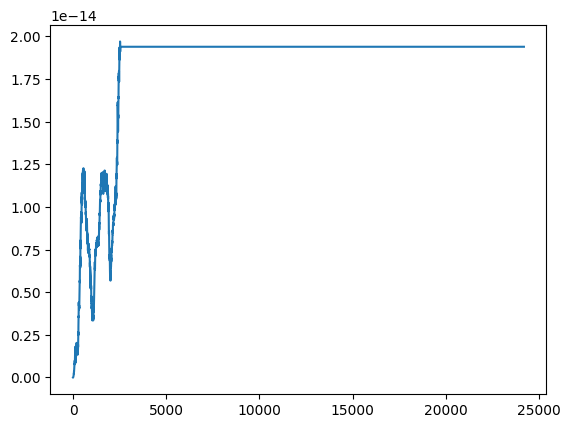

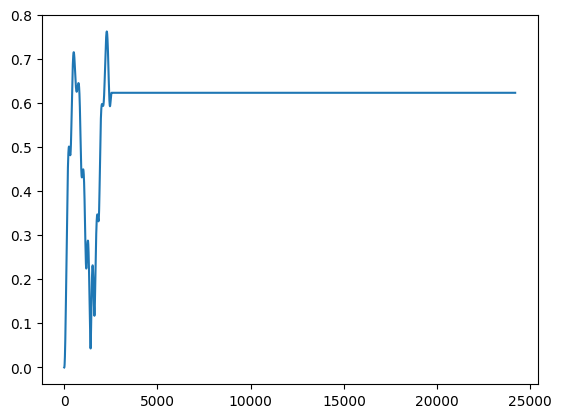

In [26]:
# S0, T1, S1, S2
# indices 0, 1, 2, 3 in python
plt.plot(np.abs(newtdcicoeffs[:,1]))
plt.show()
plt.plot(np.abs(newtdcicoeffs[:,2]))
plt.show()

In [27]:
# at once, let us compute all true 1RDM matrices in the MO basis
newrdmMO = np.einsum('ni,nj,ijab->nab',newtdcicoeffs,np.conjugate(newtdcicoeffs),bigtens.reshape((drcCI,drcCI,drc,drc)))

# these 1RDM matrices should have constant trace equal to the number of electrons
traces_p = np.einsum('ijj->i', newrdmMO)

# for H2 and HeH+, this number should be extremely close to 2, the number of electrons
print(np.mean(np.abs(traces_p)))

1.9999999999991374


In [28]:
alleigs = np.zeros((newrdmMO.shape[0], 2))
for j in range(newrdmMO.shape[0]):
    alleigs[j,:] = np.linalg.eigvalsh(newrdmMO[j,:,:])
    if j % 1000 == 0:
        print(j)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


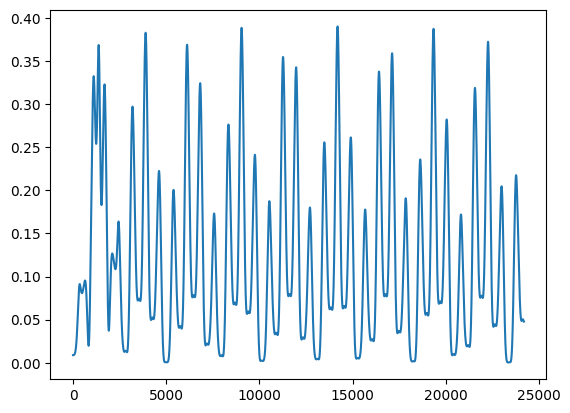

In [29]:
plt.plot(alleigs[:,0])
plt.show()

In [30]:
# at once, let us compute all full density matrices in the CI basis
tdciden = np.einsum('ni,nj->nij',newtdcicoeffs,np.conj(newtdcicoeffs))

# let us check how idempotent all of these density matrices are
# they should be idempotent, because
#   \mathbf{a}(t) \mathbf{a}(t)^\dagger \mathbf{a}(t) \mathbf{a}(t)^\dagger 
# = \mathbf{a}(t) ( \mathbf{a}(t)^\dagger \mathbf{a}(t) ) \mathbf{a}(t)^\dagger 
# = \mathbf{a}(t) (1) \mathbf{a}(t)^\dagger
# = \mathbf{a}(t) \mathbf{a}(t)^\dagger
print( np.linalg.norm(np.einsum('nij,njk->nik',tdciden,tdciden) - tdciden) )

8.67151179340095e-11


In [31]:
# reshape the 4-index tensor into a 2-index matrix
bigtens = bigtens.reshape((drcCI**2,drc**2)).astype(np.complex128)

In [32]:
# mat2vec produces a matrix that can be used to *represent*
# an n x n Hermitian matrix with constant trace via
# a real vector of size n**2

# note:
# smat = mat2vec(n) will generate a complex matrix of size n**2 x n**2

# multiplying smat by a real vector of size n**2 will generate a complex vector of size n**2,
# which when reshaped into an n x n matrix, will be Hermitian

# important technical note:
# in the real vector of size n**2, the entry at Python index location (n * (n+1))//2 - 1
# tells you what the trace of the Hermitian matrix will be!
#
# i refer to "(n * (n+1))//2 - 1" as the "magic index" below...
#

# example usage for the simplest possible Hermitian matrix, which is of size 2x2:
# 
# here n = 2, so the "magic index" (n * (n+1))//2 - 1 = 2
#
# let us say that our desired trace is 2.0 and that we want to represent the Hermitian matrix
# 
# [[ 1.0         2.0 - 3.0j ]
# [ 2.0 + 3.0j  1.0        ]]
#
# here is how we can do it:
#
# smat = mat2vec(2)
# realvec = np.array([1.0, 2.0, 2.0, -3.0])
# hermvec = smat @ realvec
# print(hermvec.reshape((2,2)))
# 
# the output of this code snippet will be
#
# [[1.+0.j 2.-3.j]
#  [2.+3.j 1.+0.j]]
#
# as desired!
#

def mat2vec(n):
    # each column of the realmat is a flattened element of the basis
    # of the vector space of all Hermitian matrices of size n x n
    # 
    # in particular, these basis elements handle the *symmetric* or *real*
    # part of the Hermitian matrix, which is why realmat's non-zero entries are 1
    realmat = np.zeros((n**2,(n+1)*n//2),dtype=np.int16)
    for i in range(n):
        for j in range(n):
            row = i*n + j
            if i<=j:
                col = i*n + j - i*(i+1)//2
            else:
                col = j*n + i - j*(j+1)//2
            realmat[row,col]=1

    # here we take care of constant trace!
    # - you will see that we index realmat[-1, j], and
    #   the "-1" is Python shorthand for "last row"
    # - what we are doing here is basically setting up the equation
    #   H_{n,n} = traceconst - H_{1,1} - H_{2,2} - ... - H_{n-1,n-1}
    # - the "traceconst" term is already taken into account via the construction above;
    #   before we run the "while" loop below, realmat[-1,:] will be zero except for one
    #   entry of 1.0 in column number (n+1)*n//2 - 1, which is of course the "magic index"
    #   that we referred to above
    # - the job of the while loop below is to replace some zeros with -1, 
    #   at locations that correspond to diagonal entries of H
    # - you can figure out what indices these are by working through the while loop logic:
    #   - j=0 corresponds to H_{1,1}
    #   - j=n corresponds to H_{2,2} because we do not store the lower-triangular entry H_{2,1}
    #   - j=2*n-1 corresponds to H_{3,3} because we do not store either H_{3,1} or H_{3,2}
    # - try it for n=4 and you will see the relationship if you write down the triangular array
    #    0 1 2 3 
    #      4 5 6 
    #        7 8 
    #          9
    j = 0
    i = 0
    while j < (realmat.shape[1] - 1):
        realmat[-1,j] = -1
        j += n - i*1
        i += 1
    
    # each column of the imagmat is a flattened element of the basis
    # of the vector space of all Hermitian matrices of size n x n
    #
    # in particular, these basis elements handle the *antisymmetric* or *imaginary*
    # part of the Hermitian matrix, which is why imagmat has both 1 and -1 entries
    imagmat = np.zeros((n**2,(n-1)*n//2),dtype=np.int16)
    for i in range(n):
        for j in range(n):
            row = i*n + j
            if i<j:
                col = i*n + j - (i+1)*(i+2)//2
                imagmat[row,col]=1
            if i>j:
                col = j*n + i - (j+1)*(j+2)//2
                imagmat[row,col]=-1
    symmat = np.hstack([realmat, 1j*imagmat])
    return symmat

smat = mat2vec(drcCI)

In [33]:
# after this code block, upper_mapping will map tuples to integers
# so, row/column indices of the upper-triangular part of a matrix
# *including the diagonal*
# get mapped to flattened vectorial indices
#
# philosophical note: as we include the diagonal here,
# we can think of this as mapping tuples to indices 
# for the **real** part of a Hermitian matrix
#
upper_mapping = {}
k = 0
for i in range(drcCI):
    for j in range(i, drcCI):
        upper_mapping[(i,j)] = k
        k += 1

# after this code block, upper_mapping will map tuples to integers
# so, row/column indices of the upper-triangular part of a matrix
# *excluding the diagonal*
# get mapped to flattened vectorial indices
#
# philosophical note: as we exclude the diagonal here,
# we can think of this as mapping tuples to indices 
# for the **imaginary** part of a Hermitian matrix
#
upper_wo_diag_mapping = {}
k = drcCI*(drcCI+1)//2
for i in range(drcCI):
    for j in range(i+1, drcCI):
        upper_wo_diag_mapping[(i,j)] = k
        k += 1

# if we have done this correctly, the following two numbers should agree,
# because there a complex Hermitian drcCI x drcCI matrix is determined by
# a total of drcCI**2 real numbers
# print(k)
# print(drcCI**2)

In [37]:
print( tdciden[100,1,:] )
print( tdciden[100,:,1] )

[-4.11772071e-16-8.27781460e-16j  8.85667026e-31+0.00000000e+00j
  1.69481875e-16-4.39978258e-17j -9.50776387e-18+1.17613649e-17j]
[-4.11772071e-16+8.27781460e-16j  8.85667026e-31+0.00000000e+00j
  1.69481875e-16+4.39978258e-17j -9.50776387e-18-1.17613649e-17j]


In [38]:
# this part here is problem-dependent!
# 
# zero_cols = list of columns of the *full CI density matrix* that are identically zero
# 
# good_cols = all other columns
# 
if mol=='h2':
    if basis=='sto-3g':
        good_cols = np.array([ 0,  2,  3])
        zero_cols = np.array([ 1])
    elif basis=='6-31g':
        good_cols = np.array([ 0,  2,  4,  5,  7,  9,  11,  12,  14,  15])
        zero_cols = np.array([ 1,  3,  6,  8,  10,  13])
elif mol=='heh+':
    if basis=='sto-3g':
        good_cols = np.array([ 0,  2,  3])
        zero_cols = np.array([ 1])
    elif basis=='6-31g':
        good_cols = np.array([ 0,  2,  4,  6,  7,  9,  11,  12,  14,  15])
        zero_cols = np.array([ 1,  3,  5,  8,  10,  13])

In [39]:
# note: because the full CI density matrix is
#       \mathbf{a}(t) \mathbf{a}(t)^\dagger,
#       if a column is identically zero then so is the corresponding row!
#       in short, this happend because a particular *entry* of the \mathbf{a}(t)
#       vector is itself identically zero (i.e., zero for all time t)
#
# another note: the words "upper" and "lower" below originate in the ordering of indices
# 
# in the vectorial real representation of a complex n x n Hermitian matrix,
# we FIRST have n*(n+1)//2 indices (the "upper" ones) that give us the real part, and
# we THEN have n*(n-1)//2 indices (the "lower" ones) that gives us the imaginary part

bad_inds = []
del_upper = 0

# loop over the (i,j) tuples in the upper_mapping dictionary
for key in list(upper_mapping.keys()):
    # loop over the zero columns defined above
    for c in zero_cols:
        # if **either** the row i or column j (in the (i,j) tuple) equals the zero column c,
        # then the vectorized index upper_mapping[(i,j)] is a "bad index";
        # for each such match, we increment our count of deleted "upper" indices
        if c in key:
            bad_inds.append(upper_mapping[key])
            del_upper+=1
            break

del_lower = 0

# loop over the (i,j) tuples in the upper_wo_diag_mapping dictionary
for key in list(upper_wo_diag_mapping.keys()):
    # loop over the zero columns defined above
    for c in zero_cols:
        # if **either** the row i or column j (in the (i,j) tuple) equals the zero column c,
        # then the vectorized index upper_mapping[(i,j)] is a "bad index";
        # for each such match, we increment our count of deleted "lower" indices
        if c in key:
            bad_inds.append(upper_wo_diag_mapping[key])
            del_lower+=1
            break


In [40]:
# before we start deleting entries from our real representation,
# this is the "magic index" that enforces the constant trace condition
magicind = drcCI*(drcCI+1)//2 - 1

# we form an array of good indices by start with 
# a vector of all indices from 0 to drcCI**2 - 1 
# and then deleting the bad indices
good_inds = np.delete(np.arange(0,drcCI**2),bad_inds)

# for convenience, we define an array consisting of all good indices
# not including the magic index
good_inds_del = good_inds[good_inds!=magicind]

# since we have deleted "del_upper" number of entries from the 
# upper triangular portion of our real representation, we must shift
# the magic index by that amount
split = magicind - del_upper

In [41]:
# these next lines of code form a sanity check
# if we combine the good and bad indices, and then sort them,
# we should end up with a vector of all indices from 0 to drcCI**2 - 1
total_inds = good_inds.tolist()
total_inds.extend(bad_inds)
total_inds.sort()
print( all(total_inds == np.arange(0,drcCI**2)) )

True


In [42]:
# copy arrays to GPU
bigtensJNP = jnp.array(bigtens)
bigtensTJNP = jnp.array(bigtens.T)
allpropJNP = jnp.array(allprop)
smatJNP = jnp.array(smat)

In [43]:
def firststep(rdmMO):
    j = ell
    allCmatT = []

    # here we form all required propagator chains
    #
    # remember that j = ell
    #
    # i=1: allpropJNP[ell-1]
    # i=2: allpropJNP[ell-1] @ allpropJNP[ell-2]
    # i=3: allpropJNP[ell-1] @ allpropJNP[ell-2] @ allpropJNP[ell-3]
    # ...
    # i=ell: allpropJNP[ell-1] @ ... @ allpropJNP[0]
    # 
    # each such propagator chain is transposed and saved in the allCmatT list
    #
    for i in range(1,ell+1):
        myexp = allpropJNP[j-i,:,:]
        if i==1:
            Cmat = myexp
        else:
            Cmat = Cmat @ myexp
        # note the transpose!
        allCmatT.append(Cmat.T)

    # this converts the allCmatT list into an array
    allCmatT = jnp.stack(allCmatT)

    #
    # see our J. Math. Phys. paper, equations (35a - 35d)
    # 
    # here we form all the blocks in the M(t) matrix;
    # note that the first block is simply bigtensTJNP,
    # which corresponds to \widetilde{B} in the paper
    #
    # in particular, each matrix of the form 
    # "bigtensTJNP @ jnp.kron( CmatT, Amat )"
    # is one of the blocks \mathscr{D}_{j} in the paper,
    # defined in equation (35a)
    #
    bigmat = []
    bigmat.append( bigtensTJNP )
    for i in range(1, ell+1):
        CmatT = allCmatT[i-1]
        Amat = CmatT.conj()
        bigmat.append( bigtensTJNP @ jnp.kron( CmatT, Amat ) )
    
    # this converts the bigmat list into an array
    bigmat = jnp.concatenate(bigmat,axis=0)

    # because this is our first very time step,
    # we rely upon an initial segment of true 1RDMs in the MO basis
    #
    # this is akin to how when you solve an ODE, you must plug in
    # the true initial condition
    #
    # here our propagation equation has memory, so we must plug in
    # an array of initial conditions, at (ell+1) discrete times
    # 0, 1, ..., ell
    btrue = jnp.flipud(rdmMO[j-ell:(j+1),:]).reshape((-1))

    # this is precisely the matrix M'(t) described in
    # Proposition 4 of our J. Math. Phys. paper
    mprime = bigmat @ smatJNP
    
    # at this stage, mprime has (ell+1)*drc**2 rows and drcCI**2 columns
    # we need to form M''(t), described in Proposition 5, and to do so
    # we select only those columns that correspond to ** non-trivial **
    # elements of the vector that forms the real representation of the
    # drcCI x drcCI Hermitian full density matrix.
    #
    # Thus we select only the columns in good_inds_del
    # 
    # Note that this excludes the column corresponding to the "magic index,"
    # because the corresponding entry of the factor is the constant trace value,
    # not something that we need to solve for.
    mdoubleprime = mprime[:,good_inds_del]

    # In the next line of code, "(btrue - bigmat[:,-1])" is the 
    # right-hand side of equation (39) in the paper, also denoted
    # \mathbf{b}_{\ell}(t) in equation (40).
    # We now begin to implement equation (41), calculating the product of
    # the pseudoinverse of M''(t) with \mathbf{b}_{\ell}(t), i.e.,
    #
    # M''(t)^{+} \mathbf{b}_{\ell}(t).
    #
    # The resulting vector should be (almost) the real representation of
    # a complex Hermitian matrix, so we take the real part.
    xxapprox = jnp.real( jnp.linalg.pinv(mdoubleprime,1e-12) @ (btrue - bigmat[:,-1]) )
    
    # We now insert the desired value (1.0) of the constant trace of the full CI
    # density matrix.  We insert this value at the "split" point computed above.
    # If we didn't have any deleted upper columns, the "split" index would be
    # precisely the same as the "magic index" mentioned above.
    #
    # The "-xxapprox" is here because of a subtle difference between how Python
    # flattens matrices versus the "vec" operation defined mathematically.
    #
    # If you visit https://en.wikipedia.org/wiki/Vectorization_(mathematics),
    # you will see that the "vec" operation is defined by concatenating *columns*.
    #
    # However, in Python, flattening a matrix via either "m.reshape((-1))"
    # or via "m.flatten()" results in a concatenation of *rows*.
    #
    # For a Hermitian matrix, the imaginary part is antisymmetric, and so to go
    # from a column-based flattening (which is what we derived mathematically)
    # to a rows-based flattening (which is what Python expects), we need to
    # multiply by -1, hence the "-xxaprox"...    
    xxapprox2 = jnp.concatenate([xxapprox[:split],jnp.array([1.0]),-xxapprox[split:]])

    # Having inserted the 1.0 in the right slot, we need to use smatJNP
    # restricted to the good indices (which includes the magic index)
    # to reconstruct the Hermitian full CI density matrix, which we then
    # unflatten by reshaping it into a matrix of size drcCI x drcCI.
    recon = (smatJNP[:,good_inds] @ xxapprox2).reshape((drcCI,drcCI))

    # sanity check to make sure recon is a Hermitian matrix
    assert (recon == recon.conjugate().transpose()).all()

    # propagate the full TDCI density matrix via one step of MMUT!
    reconprop = allpropJNP[j,:,:] @ recon @ allpropJNP[j,:,:].conj().T

    # compute new rdm
    # first we take the full TDCI density matrix we have just obtained
    # and flatten it into a vector using ".reshape((-1))", and then we
    # multiply by the \widetilde{B} matrix to convert it to a 1RDM in the MO basis.
    #
    # the final ".conj()" is to flip the sign of the imaginary part,
    # which we must do because (as explained above) there is a subtle
    # difference between row-wise Python flattening and column-wise "vec".
    nextrdmMO = (reconprop.reshape((-1)) @ bigtensJNP).conj()

    return nextrdmMO, allCmatT

In [44]:
# Think of this function as the "interior" of a for loop over the variable j
#
# Such a loop indeed occurs in the code, but it is buried below in the function call
#
# lax.fori_loop(ell+1,numsteps-1,jloopbody,(myrdmMO,newstack,residual))
#
# The advantage of writing the loop in this way is:
# JAX will JIT compile it much more quickly than if we use a basic Python for loop!
#
def loopbody(j, intup):
    rdmMO, oldstack, residuals = intup
    
    # We have already computed long chains of propagators at the
    # previous time step, and we are trying to avoid duplicating those efforts.
    # Let us unpack this in detail.
    # 
    # When we enter this function, we assume that
    # 
    # oldstack[1] = allpropJNP[j-2].T
    # oldstack[2] = allpropJNP[j-3].T @ allpropJNP[j-2].T
    # oldstack[3] = allpropJNP[j-4].T @ allpropJNP[j-3].T @ allpropJNP[j-2].T
    # ...
    # oldstack[ell] = allpropJNP[j-1-ell].T @ ... @ allpropJNP[j-2].T
    # 
    # This stack was computed at iteration j-1 and now we're at iteration j.
    # What we want to obtain is a newstack such that
    #
    # newstack[1] = allpropJNP[j-1].T
    # newstack[2] = allpropJNP[j-2].T @ allpropJNP[j-1].T
    # newstack[3] = allpropJNP[j-3].T @ allpropJNP[j-2].T @ allpropJNP[j-1].T
    # ...
    # newstack[ell] = allpropJNP[j-ell].T @ ... @ allpropJNP[j-1].T
    # 
    # Comparing oldstack and newstack, here is what we see:
    # (1) We need to multiply each oldstack[i] on the right by allpropJNP[j-1].T
    # (2) We need to multiply oldstack[i] on the left by (allpropJNP[j-(i+1)].T)^{-1}
    #     Since each propagator is unitary, the inverse is simply the conjugate transpose,
    #     which is (allpropJNP[j-(i+1)].T).T.conj() = allpropJNP[j-(i+1)].conj()
    #
    # So, in the next line of code, we access the global variable allpropJNP,
    # which itself stores all one-step propagators propagators that are needed
    # to change oldstack to newstack.
    #
    # These propagators are allpropJNP[j-(ell+1),:,:] to allpropJNP[j-2,:,:], 
    # which we extract using the "dynamic slice" in which we specify the 
    # "start index" allpropJNP[j-1-ell,0,0] followed by the "size" of the slice,
    # which is "ell" in the first slot and "drcCI" in the subsequent slots.
    #
    allpropJNPds = lax.dynamic_slice(allpropJNP,[j-1-ell,0,0],[ell,drcCI,drcCI])
    
    # Here we use einsum to update all entries of oldstack all at once!
    # Notes:
    # - the flipud is needed to put the one-step propagators in the correct order,
    #   because the first one we need is allpropJNP[j-2,:,:] and that's the *last*
    #   one in allpropJNPds
    # - the conj() is explained above and arises because we want the inverse of
    #   a transposed propagator, and the propagator is unitary to begin with
    # - "idc,icb,ab->ida" means that two multiplications are going on at once
    # - on the left, the i-th matrix in oldstack is multiplied on the left
    #   by the i-th matrix in jnp.flipud(allpropJNPds).conj(), as we can see
    #   from the "idc,ic->id" part of the expression
    # - on the right, each matrix in oldstack is multiplied by the transpose
    #   of the fixed matrix allpropJNP[j-1,:,:], as we can see from the
    #   "b,ab->a" part of the expression.
    #
    newstack = jnp.einsum('idc,icb,ab->ida',
                          jnp.flipud(allpropJNPds).conj(),
                          oldstack,
                          allpropJNP[j-1,:,:],
                          optimize=True)
    
    # see our J. Math. Phys. paper, equations (35a - 35d)
    # 
    # here we form all the blocks in the M(t) matrix;
    # note that the first block is simply bigtensTJNP,
    # which corresponds to \widetilde{B} in the paper
    #
    # in particular, each matrix of the form 
    # "bigtensTJNP @ jnp.kron( CmatT, Amat )"
    # is one of the blocks \mathscr{D}_{j} in the paper,
    # defined in equation (35a)
    #
    bigmat = []
    bigmat.append( bigtensTJNP )
    for i in range(1, ell+1):
        CmatT = newstack[i-1]
        Amat = CmatT.conj()
        bigmat.append( bigtensTJNP @ jnp.kron( CmatT, Amat ) )
    
    # this converts the bigmat list into an array
    bigmat = jnp.concatenate(bigmat,axis=0)
    
    # Reconstruct full TDCI density: here the comments are identical to those
    # in the firststep function above---the only difference is that we are now
    # using an "rdmMO" that was passed into this "loopbody" function.
    #
    # For the "second step" of propagation, rdmMO will contain "ell" entries
    # that are in fact ground truth 1RDMs, and only 1 entry that was computed via
    # our scheme (in fact computed via the "firststep" function itself!)
    #
    # For each subsequent step of propagation, the rdmMO segment will gain one
    # 1RDM computed via our scheme; correspondingly, one ground truth 1RDM will
    # exit the segment.
    #    
    rdmMOds = lax.dynamic_slice(rdmMO,[j-ell,0],[ell+1,drc**2])
    bvec = jnp.flipud(rdmMOds).reshape((-1))
    
    # this is precisely the matrix M'(t) described in
    # Proposition 4 of our J. Math. Phys. paper
    mprime = bigmat @ smatJNP
    
    # at this stage, mprime has (ell+1)*drc**2 rows and drcCI**2 columns
    # we need to form M''(t), described in Proposition 5, and to do so
    # we select only those columns that correspond to ** non-trivial **
    # elements of the vector that forms the real representation of the
    # drcCI x drcCI Hermitian full density matrix.
    #
    # Thus we select only the columns in good_inds_del
    # 
    # Note that this excludes the column corresponding to the "magic index,"
    # because the corresponding entry of the factor is the constant trace value,
    # not something that we need to solve for.
    mdoubleprime = mprime[:,good_inds_del]
    
    # this is the right-hand side of equation (39) in the paper, also denoted
    # \mathbf{b}_{\ell}(t) in equation (40).
    bellvec = bvec - bigmat[:,-1]
    
    # multiplying the pseudoinverse by a vector is *equivalent*
    # to solving a least squares problem, which is what we do here;
    # by doing it this way, we avoid forming the full matrix pseudoinverse
    #
    # for other comments, see the corresponding comments in the "firststep" function
    xxapproxtup = jnp.linalg.lstsq(mdoubleprime, bellvec, 1e-12 )
    xxapprox = jnp.real( xxapproxtup[0] )
    
    # please see the comments in the "firststep" function for the explanation
    # of why xxapprox2 is defined in this way
    xxapprox2 = jnp.concatenate([xxapprox[:split],jnp.array([1.0]),-xxapprox[split:]])
    
    # Having inserted the 1.0 in the right slot, we need to use smatJNP
    # restricted to the good indices (which includes the magic index)
    # to reconstruct the Hermitian full CI density matrix, which we then
    # unflatten by reshaping it into a matrix of size drcCI x drcCI.
    recon = (smatJNP[:,good_inds] @ xxapprox2).reshape((drcCI,drcCI))
    
    # propagate the full TDCI density matrix via one step of MMUT!
    reconprop = allpropJNP[j,:,:] @ recon @ allpropJNP[j,:,:].conj().T
    
    # compute and store new rdm
    rdmMO = rdmMO.at[j+1].set( (reconprop.reshape((-1)) @ bigtensJNP).conj() )
    
    # compute and store new residual
    residuals = residuals.at[j].set(jnp.linalg.norm(mdoubleprime @ xxapprox - bellvec))
        
    return (rdmMO, newstack, residuals)

In [45]:
# initialize empty lists to store things
rdmMOs = []
MSEs = []
residuals = []

In [46]:
# JIT compilation
jloopbody = jit(loopbody)

In [47]:
# which time delays do we want to consider
ells = np.arange(300,302,2)

In [48]:
# for each time delay, we run our 1RDM propagation code
for ell in ells:
    # start timer to measure wall clock time
    start = time.time()
    
    # here we initialize and take the first step
    myrdmMOinitblock = jnp.transpose(newrdmMO[:ell+1,:,:],(0,2,1)).reshape((-1,drc**2))
    firstnewrdmMO, newstack = firststep(myrdmMOinitblock)
    
    # here we take all subsequent steps
    numsteps = newrdmMO.shape[0]
    myrdmMO = jnp.concatenate([myrdmMOinitblock, jnp.expand_dims(firstnewrdmMO,0), 
                               jnp.zeros((numsteps-(ell+2), drc**2), dtype=np.complex128)])
    residual = jnp.zeros((numsteps-1-ell-1))
    outtup = lax.fori_loop(ell+1,numsteps-1,jloopbody,(myrdmMO,newstack,residual))
    
    # end timer to measure wall clock time
    end = time.time()
    
    # display elapsed wall clock time
    print(end-start)
    
    # now all the propagation is done, and so we extract metrics and results
    myrdmMO = outtup[0]
    MSE = jnp.mean(jnp.square(myrdmMO[ell+1:].reshape((-1,drc,drc)).conj() - newrdmMO[ell+1:]))
    MSEs.append(MSE)
    myresidual = outtup[2]
    rdmMOs.append(myrdmMO)
    residuals.append(myresidual[-1])
    print(MSEs[-1])
    print(residuals[-1])

32.520915031433105
(2.592377897511628e-22+4.6212425780359294e-30j)
6.304942367139652e-12


In [49]:
print(jnp.mean(jnp.square(myrdmMO[ell+1:].reshape((-1,drc,drc)).conj() - newrdmMO[ell+1:])))

(2.592377897511628e-22+4.6212425780359294e-30j)


In [50]:
myrdmMO[10000,:].reshape((2,2))

Array([[ 1.57073769-8.67361738e-18j, -0.29832133-7.53228572e-01j],
       [-0.29832133+7.53228572e-01j,  0.42926231+1.73472348e-18j]],      dtype=complex128)

In [51]:
newrdmMO[10000,:].reshape((2,2))

array([[ 1.57073769+0.00000000e+00j, -0.29832133+7.53228572e-01j],
       [-0.29832133-7.53228572e-01j,  0.42926231+1.73472348e-18j]])